<a href="https://colab.research.google.com/github/sean6211/PTM-predictor-evaluation/blob/main/ESMFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ESMFold**
for more details see: [Github](https://github.com/facebookresearch/esm/tree/main/esm), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1
- See [experimental notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/ESMFold_advanced.ipynb) for more advanced options (like sampling).

#### **Colab Limitations**
- For short monomeric proteins under the length 400, consider using [ESMFold API](https://esmatlas.com/resources?action=fold) (no need for GPU, super fast!)
- On Tesla T4 (typical free colab GPU), max total length ~ 900

In [1]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)
version = "1" # @param ["0", "1"]
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing libs...
installing openfold...
installing esmfold...
CPU times: user 9.71 ms, sys: 5 ms, total: 14.7 ms
Wall time: 2min 54s


In [2]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 68
ptm: 0.817 plddt: 90.518
CPU times: user 13 s, sys: 6.47 s, total: 19.5 s
Wall time: 20 s


In [3]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

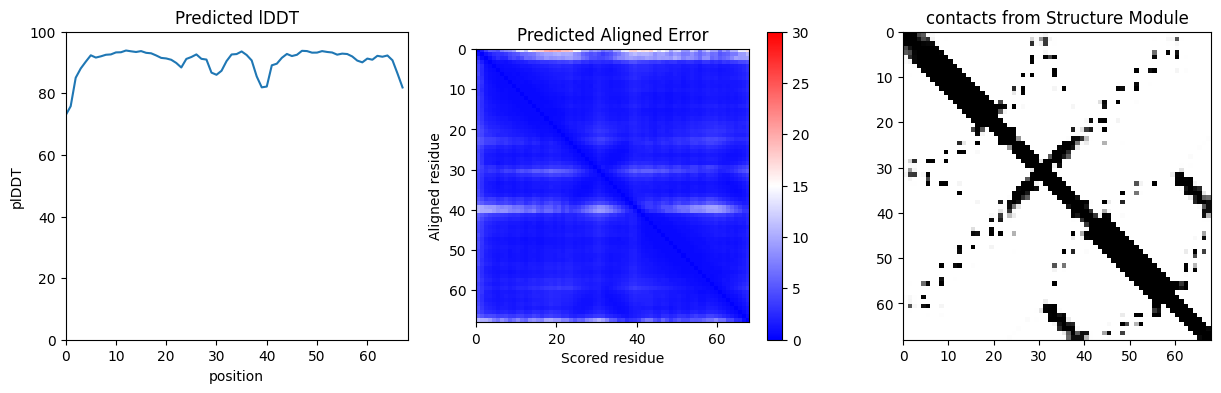

In [4]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [5]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
%%time
# Install official ESM + ESMFold and utilities
!pip install -q "fair-esm[esmfold]" biotite

import math
import random
from pathlib import Path
from tempfile import NamedTemporaryFile

import numpy as np
import torch
import biotite.structure.io as bsio
import esm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.3 MB/s eta 0:00:00
CPU times: user 2.33 s, sys: 301 ms, total: 2.63 s
Wall time: 15.3 s


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#############################################
# Load ESM-2 (35M) sequence model
#############################################

lm_model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
lm_model = lm_model.to(device)
lm_model.eval()  # no backprop, ES is gradient-free

AA_LETTERS = list("ACDEFGHIKLMNPQRSTVWY")
AA_INDICES = torch.tensor([alphabet.get_idx(a) for a in AA_LETTERS], device=device)

mask_idx = alphabet.mask_idx
cls_idx  = alphabet.cls_idx
eos_idx  = alphabet.eos_idx

print("Loaded ESM-2 35M model.")

#############################################
# Load ESMFold structure model (black-box)
#############################################

fold_model = esm.pretrained.esmfold_v1()
fold_model = fold_model.eval().to(device)
fold_model.set_chunk_size(128)  # mildly more memory-efficient on Colab

print("Loaded ESMFold v1.")


Using device: cuda
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt
Loaded ESM-2 35M model.
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esmfold_3B_v1.pt" to /root/.cache/torch/hub/checkpoints/esmfold_3B_v1.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t36_3B_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t36_3B_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D-contact-regression.pt
Loaded ESMFold v1.


In [8]:
@torch.no_grad()
def sample_sequence_from_lm(
    model,
    alphabet,
    length=100,
    temperature=1.0,
    device=device,
):
    """
    Simple left-to-right generation using ESM-2 as a pseudo autoregressive LM.
    """
    total_len = length + 2  # [CLS] + L tokens + [EOS]
    tokens = torch.full((1, total_len), fill_value=mask_idx, device=device, dtype=torch.long)
    tokens[0, 0] = cls_idx
    tokens[0, -1] = eos_idx

    for pos in range(1, length + 1):
        tokens[0, pos] = mask_idx
        out = model(tokens, repr_layers=[], return_contacts=False)
        logits = out["logits"][0, pos]  # (vocab_size,)

        # Restrict to the 20 standard amino acids
        aa_logits = logits[AA_INDICES]
        probs = torch.softmax(aa_logits / temperature, dim=-1)

        # Sample one amino acid
        aa_idx = torch.multinomial(probs, num_samples=1)
        tok_id = AA_INDICES[aa_idx]
        tokens[0, pos] = tok_id

    seq_tokens = tokens[0, 1:-1].tolist()
    seq = "".join(alphabet.get_tok(t) for t in seq_tokens)
    return seq


# Quick sanity check
test_seq = sample_sequence_from_lm(lm_model, alphabet, length=60, temperature=1.0)
print("Example generated sequence:", test_seq)
print("Length:", len(test_seq))

Example generated sequence: MSIPCVSALSPDDAPTVAPCRGDDVVTVPCAPDRDRGPLFCISMPRPTCRRAVPAERLHS
Length: 60


In [9]:
@torch.no_grad()
def evaluate_sequence_with_esmfold(
    sequence: str,
    fold_model=fold_model,
    device=device,
) -> float:
    """
    Black-box reward: ESMFold structure prediction + mean pLDDT.
    """
    pdb_str = fold_model.infer_pdb(sequence)

    with NamedTemporaryFile("w+", suffix=".pdb") as tmp:
        tmp.write(pdb_str)
        tmp.flush()
        struct = bsio.load_structure(tmp.name, extra_fields=["b_factor"])

    mean_plddt = float(struct.b_factor.mean())
    return mean_plddt


def evaluate_model_once(
    num_sequences=3,
    seq_length=80,
    temperature=1.0,
):
    """
    For the *current* lm_model parameters, generate sequences,
    score each with ESMFold, and return the average score.
    """
    scores = []
    for _ in range(num_sequences):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        scores.append(score)
    return float(np.mean(scores)), scores

In [10]:
import torch.nn as nn

class EggrollContext:
    """
    Global context used by hooked Linear layers to decide
    whether to inject low-rank noise and which noise to use.
    """
    def __init__(self, device):
        self.active    = False  # enable/disable noise
        self.rank      = 0      # low-rank dimension r
        self.sigma     = 0.0    # noise scale
        self.thread_id = 0      # population member index
        self.device    = device

egg_ctx = EggrollContext(device)

# Hook all Linear layers in the ESM-2 model
lin_modules = []  # (name, module, base_key)

for name, module in lm_model.named_modules():
    if isinstance(module, nn.Linear):
        base_key = random.randint(0, 2**31 - 1)
        lin_modules.append((name, module, base_key))
        orig_forward = module.forward

        def make_forward(m, orig, base_key):
            def forward_with_low_rank(x, _orig=orig, _module=m, _base_key=base_key):
                # Base linear output
                out = _orig(x)
                if egg_ctx.active and _module.weight.ndim == 2:
                    weight = _module.weight
                    out_features, in_features = weight.shape

                    # Deterministic RNG for (layer, thread_id)
                    g = torch.Generator(device=egg_ctx.device)
                    combined_seed = (_base_key ^ egg_ctx.thread_id) & 0x7FFFFFFF
                    g.manual_seed(combined_seed)

                    r = egg_ctx.rank
                    if r > 0:
                        perturb = torch.randn(
                            in_features + out_features,
                            r,
                            generator=g,
                            device=egg_ctx.device,
                        )
                        B = perturb[:in_features, :]      # (in, r)
                        A = perturb[in_features:, :]      # (out, r)

                        # LoRA-style adapter: x @ B -> (batch, r); then @ A^T -> (batch, out)
                        adapter = x @ B
                        adapter = adapter @ A.t()
                        out = out + egg_ctx.sigma * adapter / math.sqrt(r)

                return out
            return forward_with_low_rank

        module.forward = make_forward(module, orig_forward, base_key)

print(f"Hooked {len(lin_modules)} Linear modules for EGGROLL-style noise.")

Hooked 74 Linear modules for EGGROLL-style noise.


In [11]:
# Map parameter names to tensor objects
name_to_param = dict(lm_model.named_parameters())

# Track only the 2D Linear weight matrices that correspond to hooked modules
linear_weights = []  # (param_name, param_tensor, base_key)

for name, module, base_key in lin_modules:
    w_name = name + ".weight"
    if w_name in name_to_param:
        linear_weights.append((w_name, name_to_param[w_name], base_key))

print("Number of Linear weight matrices to optimize:", len(linear_weights))

Number of Linear weight matrices to optimize: 74


In [12]:
@torch.no_grad()
def accumulate_linear_grad_buffers(
    grad_buffers,
    linear_weights,
    rank,
    sigma,
    thread_id,
    device,
    weight,
):
    """
    Re-generate the low-rank noise for each Linear weight and accumulate
    weight * sigma * ΔW into grad_buffers[name].
    """
    for param_name, param, base_key in linear_weights:
        out_features, in_features = param.data.shape

        g = torch.Generator(device=device)
        combined_seed = (base_key ^ thread_id) & 0x7FFFFFFF
        g.manual_seed(combined_seed)

        perturb = torch.randn(
            in_features + out_features,
            rank,
            generator=g,
            device=device,
        )
        B = perturb[:in_features, :]     # (in, r)
        A = perturb[in_features:, :]     # (out, r)
        delta = (A @ B.t()) / math.sqrt(rank)  # (out, in)

        if param_name not in grad_buffers:
            grad_buffers[param_name] = torch.zeros_like(param.data)
        grad_buffers[param_name].add_(weight * sigma * delta)


@torch.no_grad()
def es_step_eggroll(
    lm_model,
    linear_weights,
    rank,
    sigma,
    pop_size,
    lr,
    device,
    eval_fn,
    num_sequences,
    seq_length,
    temperature,
):
    """
    One EGGROLL-style ES step:
      - Evaluate pop_size perturbations via low-rank LoRA-like forward
      - Compute normalized rewards
      - Reconstruct perturbations to form a full-rank update
    """
    rewards = []

    # 1) Evaluate each population member
    for j in range(pop_size):
        egg_ctx.active    = True
        egg_ctx.rank      = rank
        egg_ctx.sigma     = sigma
        egg_ctx.thread_id = j

        mean_score, _ = eval_fn(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )
        rewards.append(mean_score)

    # Turn off perturbations afterwards
    egg_ctx.active = False

    rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)

    # 2) Normalize rewards (zero-mean, unit variance)
    if rewards_t.std() > 1e-8:
        norm_rewards = (rewards_t - rewards_t.mean()) / (rewards_t.std() + 1e-8)
    else:
        norm_rewards = rewards_t - rewards_t.mean()

    # 3) Accumulate gradient estimate in parameter space
    grad_buffers = {}
    for j, R in enumerate(norm_rewards):
        accumulate_linear_grad_buffers(
            grad_buffers,
            linear_weights,
            rank=rank,
            sigma=sigma,
            thread_id=j,
            device=device,
            weight=R.item(),
        )

    # 4) Apply update: θ_new = θ + lr * grad_estimate
    scale = lr / (pop_size * (sigma**2 + 1e-8))
    for param_name, param, base_key in linear_weights:
        param.data.add_(scale * grad_buffers[param_name])

    return float(rewards_t.mean().item()), float(rewards_t.max().item()), rewards

In [13]:
##########################################
# ES hyperparameters (Colab-friendly)
##########################################

SEQ_LENGTH      = 60       # amino acids per sequence
NUM_SEQUENCES   = 2        # sequences per population member
POP_SIZE        = 4        # ES population size
RANK            = 4        # low-rank dimension r
SIGMA           = 0.05     # noise scale
LR              = 0.1      # learning rate in parameter space
NUM_STEPS       = 3        # ES iterations (increase if GPU allows)
TEMPERATURE     = 1.0      # sampling temperature for LM

print("=== ES CONFIGURATION ===")
print(f"SEQ_LENGTH    = {SEQ_LENGTH}")
print(f"NUM_SEQUENCES = {NUM_SEQUENCES}")
print(f"POP_SIZE      = {POP_SIZE}")
print(f"RANK          = {RANK}")
print(f"SIGMA         = {SIGMA}")
print(f"LR            = {LR}")
print(f"NUM_STEPS     = {NUM_STEPS}")


def eval_fn(num_sequences=NUM_SEQUENCES, seq_length=SEQ_LENGTH, temperature=TEMPERATURE):
    return evaluate_model_once(
        num_sequences=num_sequences,
        seq_length=seq_length,
        temperature=temperature,
    )


##########################################
# Run ES
##########################################

history = []

for step in range(1, NUM_STEPS + 1):
    avg_reward, max_reward, all_rewards = es_step_eggroll(
        lm_model,
        linear_weights,
        rank=RANK,
        sigma=SIGMA,
        pop_size=POP_SIZE,
        lr=LR,
        device=device,
        eval_fn=eval_fn,
        num_sequences=NUM_SEQUENCES,
        seq_length=SEQ_LENGTH,
        temperature=TEMPERATURE,
    )
    history.append((avg_reward, max_reward))
    print(f"[Step {step}] avg reward = {avg_reward:.2f}, max reward = {max_reward:.2f}")

=== ES CONFIGURATION ===
SEQ_LENGTH    = 60
NUM_SEQUENCES = 2
POP_SIZE      = 4
RANK          = 4
SIGMA         = 0.05
LR            = 0.1
NUM_STEPS     = 3
[Step 1] avg reward = 48.57, max reward = 55.81
[Step 2] avg reward = 45.96, max reward = 49.51
[Step 3] avg reward = 44.57, max reward = 49.06


In [14]:
@torch.no_grad()
def sample_and_score_n(n=3, length=SEQ_LENGTH):
    seqs = []
    scores = []
    for _ in range(n):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=length,
            temperature=TEMPERATURE,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        seqs.append(seq)
        scores.append(score)
    return seqs, scores


print("\nSampling sequences from the (possibly optimized) model...")
final_seqs, final_scores = sample_and_score_n(n=3, length=SEQ_LENGTH)

for i, (s, sc) in enumerate(zip(final_seqs, final_scores), 1):
    print(f"\nSequence {i} (mean pLDDT {sc:.2f}):\n{s}")


Sampling sequences from the (possibly optimized) model...

Sequence 1 (mean pLDDT 35.43):
NMDCICCWYAEDDIIAMGGTQERMQEGGTETLDHLGYCLKKMSSITRAIDTYTIMEYGEM

Sequence 2 (mean pLDDT 34.39):
INNLLCIGDGTVLVYISLIGNKRTCNHEMQIMNRTGYGMECNGSGKAVSPIEKVVVQGMM

Sequence 3 (mean pLDDT 42.59):
GYGINEPAALCYKEKVGYSAGAKELMEAEKMGCILLIVISVGIFGINGGRHVLLEMLWEQ


In [15]:
%%time
import numpy as np

##########################################
# 1) Measure a proper baseline
##########################################

# We'll use the same length we train on
TRAIN_SEQ_LENGTH = 60

baseline_mean, baseline_scores = evaluate_model_once(
    num_sequences=10,
    seq_length=TRAIN_SEQ_LENGTH,
    temperature=1.0,
)
print(f"[Baseline] mean pLDDT over 10 sequences: {baseline_mean:.2f}")
print("Individual scores:", [f"{s:.2f}" for s in baseline_scores])

##########################################
# 2) New ES hyperparameters (more stable)
##########################################

TRAIN_NUM_SEQUENCES = 4   # more sequences per member → less noisy rewards
TRAIN_POP_SIZE      = 8   # larger population if GPU allows
TRAIN_RANK          = 4   # low-rank dimension (keep small for Colab)
TRAIN_SIGMA         = 0.02
TRAIN_LR            = 0.03
TRAIN_NUM_STEPS     = 20  # more ES iterations
TRAIN_TEMPERATURE   = 1.0

print("\n=== NEW ES CONFIGURATION ===")
print(f"TRAIN_SEQ_LENGTH    = {TRAIN_SEQ_LENGTH}")
print(f"TRAIN_NUM_SEQUENCES = {TRAIN_NUM_SEQUENCES}")
print(f"TRAIN_POP_SIZE      = {TRAIN_POP_SIZE}")
print(f"TRAIN_RANK          = {TRAIN_RANK}")
print(f"TRAIN_SIGMA         = {TRAIN_SIGMA}")
print(f"TRAIN_LR            = {TRAIN_LR}")
print(f"TRAIN_NUM_STEPS     = {TRAIN_NUM_STEPS}")

##########################################
# 3) Restrict which layers we mutate
##########################################
# Instead of updating all 74 Linear weights, we only update the last few.
# This often stabilizes training and keeps the model closer to its pretrained prior.

NUM_LINEAR_TO_TRAIN = 24  # you can change this (e.g., 16, 32, etc.)

if len(linear_weights) <= NUM_LINEAR_TO_TRAIN:
    trained_linear_weights = linear_weights
    print(f"\nTraining ALL {len(trained_linear_weights)} Linear weights.")
else:
    trained_linear_weights = linear_weights[-NUM_LINEAR_TO_TRAIN:]
    print(f"\nTraining ONLY the last {NUM_LINEAR_TO_TRAIN} Linear weights out of {len(linear_weights)} total.")

# Small helper so es_step_eggroll can call evaluate_model_once with named args
def train_eval_fn(num_sequences, seq_length, temperature):
    return evaluate_model_once(
        num_sequences=num_sequences,
        seq_length=seq_length,
        temperature=temperature,
    )


[Baseline] mean pLDDT over 10 sequences: 41.58
Individual scores: ['56.93', '45.30', '34.24', '39.49', '41.08', '35.75', '48.34', '35.00', '38.34', '41.33']

=== NEW ES CONFIGURATION ===
TRAIN_SEQ_LENGTH    = 60
TRAIN_NUM_SEQUENCES = 4
TRAIN_POP_SIZE      = 8
TRAIN_RANK          = 4
TRAIN_SIGMA         = 0.02
TRAIN_LR            = 0.03
TRAIN_NUM_STEPS     = 20

Training ONLY the last 24 Linear weights out of 74 total.
CPU times: user 23.2 s, sys: 0 ns, total: 23.2 s
Wall time: 23.2 s


In [16]:
%%time
history = []  # list of (avg_reward, max_reward)

print("\n=== Starting ES training ===")
for step in range(1, TRAIN_NUM_STEPS + 1):
    avg_reward, max_reward, all_rewards = es_step_eggroll(
        lm_model,
        trained_linear_weights,      # <--- restricted subset
        rank=TRAIN_RANK,
        sigma=TRAIN_SIGMA,
        pop_size=TRAIN_POP_SIZE,
        lr=TRAIN_LR,
        device=device,
        eval_fn=train_eval_fn,
        num_sequences=TRAIN_NUM_SEQUENCES,
        seq_length=TRAIN_SEQ_LENGTH,
        temperature=TRAIN_TEMPERATURE,
    )
    history.append((avg_reward, max_reward))
    print(
        f"[Step {step:02d}] "
        f"avg reward = {avg_reward:.2f}, "
        f"max reward = {max_reward:.2f}, "
        f"pop rewards = {[f'{r:.2f}' for r in all_rewards]}"
    )

##########################################
# Post-training evaluation (same as baseline)
##########################################
post_mean, post_scores = evaluate_model_once(
    num_sequences=10,
    seq_length=TRAIN_SEQ_LENGTH,
    temperature=1.0,
)
print("\n=== Baseline vs Post-training ===")
print(f"Baseline mean pLDDT over 10 seqs: {baseline_mean:.2f}")
print(f"Post-train mean pLDDT over 10 seqs: {post_mean:.2f}")
print("Post-train individual scores:", [f"{s:.2f}" for s in post_scores])



=== Starting ES training ===
[Step 01] avg reward = 41.89, max reward = 45.01, pop rewards = ['42.87', '43.89', '39.91', '41.15', '39.19', '40.60', '45.01', '42.52']
[Step 02] avg reward = 40.32, max reward = 47.28, pop rewards = ['37.71', '36.51', '38.77', '42.43', '38.48', '39.68', '41.69', '47.28']
[Step 03] avg reward = 42.39, max reward = 45.58, pop rewards = ['42.00', '45.58', '44.60', '43.17', '40.86', '45.23', '39.69', '38.00']
[Step 04] avg reward = 40.15, max reward = 41.83, pop rewards = ['41.83', '40.63', '37.65', '39.45', '39.28', '41.51', '40.79', '40.04']
[Step 05] avg reward = 45.66, max reward = 48.62, pop rewards = ['46.64', '42.60', '46.21', '42.75', '45.73', '48.62', '47.13', '45.63']
[Step 06] avg reward = 40.92, max reward = 44.64, pop rewards = ['39.25', '38.22', '41.24', '41.69', '40.90', '44.64', '40.91', '40.50']
[Step 07] avg reward = 38.56, max reward = 43.30, pop rewards = ['41.28', '43.30', '35.98', '39.98', '36.28', '37.43', '35.39', '38.85']
[Step 08] a

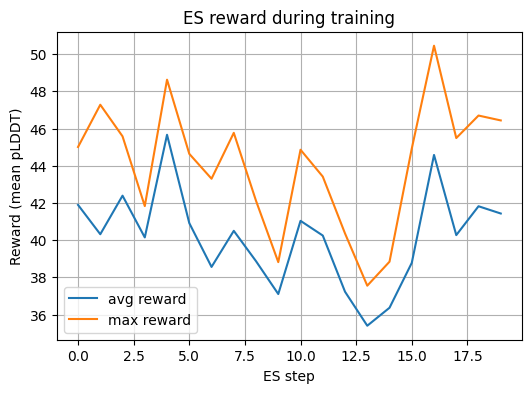


=== Sampling from final (ES-updated) model ===

Sequence 1 (mean pLDDT 40.23):
NNLDNSLKKNRRCMIDSKHIKFKYKQELRNKNIINKKRLGWRKYKDAHIGGKHGIICACI

Sequence 2 (mean pLDDT 51.96):
KSCIKGRYWPWKKLSRKNSFINYKKLYILRYARGIRKCWWEEFKSYRAYKKSWRRERDAK

Sequence 3 (mean pLDDT 41.15):
NLIKKKKLPNRSWIIRKEIWIGGSIEPLKSKMIIWSEYMKAAHIRYGRSPRQIINLLVKF


In [17]:
import matplotlib.pyplot as plt

##########################################
# Plot avg and max reward vs training step
##########################################

avg_hist = [a for (a, m) in history]
max_hist = [m for (a, m) in history]

plt.figure(figsize=(6,4))
plt.plot(avg_hist, label="avg reward")
plt.plot(max_hist, label="max reward")
plt.xlabel("ES step")
plt.ylabel("Reward (mean pLDDT)")
plt.title("ES reward during training")
plt.legend()
plt.grid(True)
plt.show()

##########################################
# Sample and score a few sequences from the final model
##########################################

@torch.no_grad()
def sample_and_score_n(n=3, length=TRAIN_SEQ_LENGTH):
    seqs = []
    scores = []
    for _ in range(n):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=length,
            temperature=TRAIN_TEMPERATURE,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        seqs.append(seq)
        scores.append(score)
    return seqs, scores

print("\n=== Sampling from final (ES-updated) model ===")
final_seqs, final_scores = sample_and_score_n(n=3, length=TRAIN_SEQ_LENGTH)

for i, (s, sc) in enumerate(zip(final_seqs, final_scores), 1):
    print(f"\nSequence {i} (mean pLDDT {sc:.2f}):\n{s}")


In [18]:
%%time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

##########################################
# 1. CONFIG (edit these to trade off runtime vs robustness)
##########################################

N_EXPERIMENTS          = 3      # number of ES runs with different seeds (e.g. 3–5)
BASELINE_N_SEQS        = 30     # sequences for baseline evaluation (30–50 recommended)
POST_N_SEQS            = 30     # sequences for post-training evaluation
EVAL_SEQ_LENGTH        = 60
EVAL_TEMPERATURE       = 1.0

# ES training hyperparameters PER EXPERIMENT
TRAIN_SEQ_LENGTH       = 60
TRAIN_NUM_SEQUENCES    = 4      # sequences per population member per step
TRAIN_POP_SIZE         = 8      # population size (try 8–16 if GPU allows)
TRAIN_RANK             = 4      # low-rank dimension
TRAIN_SIGMA            = 0.02
TRAIN_LR               = 0.03
TRAIN_NUM_STEPS        = 15     # steps per experiment (30 is stronger but slower)
TRAIN_TEMPERATURE      = 1.0

# Which subset of linear layers to train (last K)
NUM_LINEAR_TO_TRAIN    = 24

print("=== MULTI-RUN CONFIG ===")
print(f"N_EXPERIMENTS         = {N_EXPERIMENTS}")
print(f"BASELINE_N_SEQS       = {BASELINE_N_SEQS}")
print(f"POST_N_SEQS           = {POST_N_SEQS}")
print(f"TRAIN_POP_SIZE        = {TRAIN_POP_SIZE}")
print(f"TRAIN_NUM_STEPS       = {TRAIN_NUM_STEPS}")
print(f"TRAIN_NUM_SEQUENCES   = {TRAIN_NUM_SEQUENCES}")
print(f"NUM_LINEAR_TO_TRAIN   = {NUM_LINEAR_TO_TRAIN}")

##########################################
# 2. Choose subset of linear weights to train
##########################################

if len(linear_weights) <= NUM_LINEAR_TO_TRAIN:
    trained_linear_weights_global = linear_weights
    print(f"\nTraining ALL {len(trained_linear_weights_global)} Linear weights.")
else:
    trained_linear_weights_global = linear_weights[-NUM_LINEAR_TO_TRAIN:]
    print(f"\nTraining ONLY the last {NUM_LINEAR_TO_TRAIN} Linear weights out of {len(linear_weights)} total.")

##########################################
# 3. Save a base copy of the model to reset each experiment
##########################################

base_state_dict = {k: v.detach().cpu().clone() for k, v in lm_model.state_dict().items()}
print("\nSaved base model state for resetting between experiments.")


##########################################
# 4. Helper: evaluate model distribution (mean, std, tails)
##########################################

@torch.no_grad()
def evaluate_model_distribution(
    n_sequences: int,
    seq_length: int,
    temperature: float,
):
    """
    Generate n_sequences from the *current* lm_model, score with ESMFold,
    and return a dict with mean, std, and tail fractions.
    """
    scores = []
    for _ in range(n_sequences):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        scores.append(score)

    scores = np.array(scores, dtype=np.float32)
    mean_score = float(scores.mean())
    std_score  = float(scores.std(ddof=1)) if len(scores) > 1 else 0.0
    frac_gt_60 = float((scores > 60.0).mean())
    frac_lt_30 = float((scores < 30.0).mean())

    metrics = {
        "mean": mean_score,
        "std": std_score,
        "frac_gt_60": frac_gt_60,
        "frac_lt_30": frac_lt_30,
        "scores": scores,
    }
    return metrics


=== MULTI-RUN CONFIG ===
N_EXPERIMENTS         = 3
BASELINE_N_SEQS       = 30
POST_N_SEQS           = 30
TRAIN_POP_SIZE        = 8
TRAIN_NUM_STEPS       = 15
TRAIN_NUM_SEQUENCES   = 4
NUM_LINEAR_TO_TRAIN   = 24

Training ONLY the last 24 Linear weights out of 74 total.

Saved base model state for resetting between experiments.
CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 55.9 ms


In [ ]:
%%time
import random

def run_es_experiment(exp_id: int, seed: int):
    """
    Run one ES experiment:
      1) Reset model to base_state_dict
      2) Evaluate baseline distribution
      3) Run ES training
      4) Evaluate post-training distribution
    Returns a dict with baseline + post metrics and training history.
    """
    print(f"\n====================")
    print(f"Starting experiment {exp_id} with seed {seed}")
    print(f"====================")

    # --- Set seeds for reproducibility ---
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # --- Reset model to base state ---
    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    # --- Evaluate baseline distribution ---
    baseline_metrics = evaluate_model_distribution(
        n_sequences=BASELINE_N_SEQS,
        seq_length=EVAL_SEQ_LENGTH,
        temperature=EVAL_TEMPERATURE,
    )
    print(
        f"[Exp {exp_id}] Baseline mean pLDDT = {baseline_metrics['mean']:.2f} "
        f"+/- {baseline_metrics['std']:.2f}, "
        f"frac>60 = {baseline_metrics['frac_gt_60']:.2f}, "
        f"frac<30 = {baseline_metrics['frac_lt_30']:.2f}"
    )

    # --- ES training loop ---
    history = []  # (avg_reward, max_reward)
    def train_eval_fn(num_sequences, seq_length, temperature):
        return evaluate_model_once(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )

    for step in range(1, TRAIN_NUM_STEPS + 1):
        avg_reward, max_reward, all_rewards = es_step_eggroll(
            lm_model,
            trained_linear_weights_global,
            rank=TRAIN_RANK,
            sigma=TRAIN_SIGMA,
            pop_size=TRAIN_POP_SIZE,
            lr=TRAIN_LR,
            device=device,
            eval_fn=train_eval_fn,
            num_sequences=TRAIN_NUM_SEQUENCES,
            seq_length=TRAIN_SEQ_LENGTH,
            temperature=TRAIN_TEMPERATURE,
        )
        history.append((avg_reward, max_reward))
        print(
            f"[Exp {exp_id} | Step {step:02d}] "
            f"avg = {avg_reward:.2f}, max = {max_reward:.2f}"
        )

    # --- Evaluate post-training distribution ---
    post_metrics = evaluate_model_distribution(
        n_sequences=POST_N_SEQS,
        seq_length=EVAL_SEQ_LENGTH,
        temperature=EVAL_TEMPERATURE,
    )
    print(
        f"[Exp {exp_id}] Post-train mean pLDDT = {post_metrics['mean']:.2f} "
        f"+/- {post_metrics['std']:.2f}, "
        f"frac>60 = {post_metrics['frac_gt_60']:.2f}, "
        f"frac<30 = {post_metrics['frac_lt_30']:.2f}"
    )

    return {
        "exp_id": exp_id,
        "seed": seed,
        "baseline": baseline_metrics,
        "post": post_metrics,
        "history": history,
    }


##########################################
# Run multiple experiments with different seeds
##########################################

experiment_results = []

base_seed = 12345  # change this if you like
for i in range(N_EXPERIMENTS):
    seed = base_seed + i
    res = run_es_experiment(exp_id=i, seed=seed)
    experiment_results.append(res)

print("\n=== Finished all experiments ===")



Starting experiment 0 with seed 12345
[Exp 0] Baseline mean pLDDT = 47.86 +/- 8.52, frac>60 = 0.10, frac<30 = 0.00
[Exp 0 | Step 01] avg = 49.11, max = 70.71
[Exp 0 | Step 02] avg = 57.03, max = 61.29
[Exp 0 | Step 03] avg = 57.58, max = 70.71
[Exp 0 | Step 04] avg = 54.84, max = 64.84


In [ ]:
%%time
# Aggregate baseline vs post across experiments

baseline_means = [r["baseline"]["mean"] for r in experiment_results]
post_means     = [r["post"]["mean"] for r in experiment_results]

baseline_fracs_gt60 = [r["baseline"]["frac_gt_60"] for r in experiment_results]
post_fracs_gt60     = [r["post"]["frac_gt_60"] for r in experiment_results]

baseline_fracs_lt30 = [r["baseline"]["frac_lt_30"] for r in experiment_results]
post_fracs_lt30     = [r["post"]["frac_lt_30"] for r in experiment_results]

def summarize(arr):
    arr = np.array(arr, dtype=np.float32)
    return float(arr.mean()), float(arr.std(ddof=1) if len(arr) > 1 else 0.0)

b_mean, b_std = summarize(baseline_means)
p_mean, p_std = summarize(post_means)

b_gt60_mean, b_gt60_std = summarize(baseline_fracs_gt60)
p_gt60_mean, p_gt60_std = summarize(post_fracs_gt60)

b_lt30_mean, b_lt30_std = summarize(baseline_fracs_lt30)
p_lt30_mean, p_lt30_std = summarize(post_fracs_lt30)

print("=== Aggregate over experiments ===")
print(f"Baseline mean pLDDT: {b_mean:.2f} +/- {b_std:.2f}")
print(f"Post-train mean pLDDT: {p_mean:.2f} +/- {p_std:.2f}")
print()
print(f"Baseline frac>60: {b_gt60_mean:.2f} +/- {b_gt60_std:.2f}")
print(f"Post-train  frac>60: {p_gt60_mean:.2f} +/- {p_gt60_std:.2f}")
print()
print(f"Baseline frac<30: {b_lt30_mean:.2f} +/- {b_lt30_std:.2f}")
print(f"Post-train  frac<30: {p_lt30_mean:.2f} +/- {p_lt30_std:.2f}")

##########################################
# Optional: visualize distributions for one experiment
##########################################

exp_to_plot = 0  # index of experiment to inspect

baseline_scores = experiment_results[exp_to_plot]["baseline"]["scores"]
post_scores     = experiment_results[exp_to_plot]["post"]["scores"]

plt.figure(figsize=(7,4))
plt.hist(baseline_scores, bins=15, alpha=0.6, label="baseline")
plt.hist(post_scores, bins=15, alpha=0.6, label="post-train")
plt.xlabel("pLDDT")
plt.ylabel("Count")
plt.title(f"pLDDT distribution (experiment {exp_to_plot})")
plt.legend()
plt.grid(True)
plt.show()

##########################################
# Optional: plot ES reward curves for one experiment
##########################################

history0 = experiment_results[exp_to_plot]["history"]
avg_hist = [a for (a, m) in history0]
max_hist = [m for (a, m) in history0]

plt.figure(figsize=(6,4))
plt.plot(avg_hist, label="avg reward")
plt.plot(max_hist, label="max reward")
plt.xlabel("ES step")
plt.ylabel("Reward (mean pLDDT)")
plt.title(f"ES reward during training (experiment {exp_to_plot})")
plt.legend()
plt.grid(True)
plt.show()
